# 1. Configuration & Imports

In [1]:
# 1. Remove old folder if it exists
!rm -rf YourRepoName

# 2. Clone your code
!git clone https://github.com/mazennh/Gesture-Classification.git

# 3. Install dependencies
!pip install -r /kaggle/working/Gesture-Classification/requirements.txt --quiet

# 4. Allow Python to find your files
import sys
import os
sys.path.append(os.path.abspath("/kaggle/working/Gesture-Classification"))

# 5. Auto-reload (Optional: helps if you edit code and git pull)
%load_ext autoreload
%autoreload 2

print("Setup Complete! Your custom modules are ready.")

Cloning into 'Gesture-Classification'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 28 (delta 12), reused 11 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (28/28), 12.98 KiB | 4.33 MiB/s, done.
Resolving deltas: 100% (12/12), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 5.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.1 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.1 which is incompatible.
g

In [ ]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))

In [ ]:
import torch
import zipfile
import torch.nn as nn
import os
import subprocess
import warnings
from pyngrok import ngrok
from utils import data_utils
from utils import model_utils
from utils import vis_utils

warnings.filterwarnings("ignore")
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2025-12-15 13:01:28.282219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765803688.498996      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765803688.567786      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'cuda'

# 2. Model Evaluation

## 2.1 Unzip Best Model

In [3]:
zip_file_path = "/kaggle/input/gesture-classification-vit/_output_.zip"
extract_to = "/kaggle/working/unzipped_data"
os.makedirs(extract_to, exist_ok=True)
print("Unzipping...")
!unzip -q "{zip_file_path}" -d "{extract_to}"
print(f"Files extracted to: {extract_to}")

Unzipping...
Files extracted to: /kaggle/working/unzipped_data


## 2.2 Model Evaluation

In [4]:
dls = data_utils.create_dataloaders(
    data_dir="/kaggle/working/unzipped_data/splited_data",
    batch_size=32,
    img_size=224
)

_, _, test_dataloader, _, class_names, _ = dls


Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
===
Train data:
Dataset ImageFolder
    Number of datapoints: 202362
    Root location: /kaggle/working/unzipped_data/splited_data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.7, 1.3), contrast=(0.7, 1.3), saturation=None, hue=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Val Data:
Dataset ImageFolder
    Number of datapoints: 25293
    Root location: /kaggle/working/unzipped_data/splited_data/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, an

In [5]:
loss_fn = nn.CrossEntropyLoss()

Loading ViT-B/16...


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 176MB/s]  


Running final evaluation...
FINAL TEST METRICS
Accuracy:  92.66%
AUC Score: 0.9965
Loss:      0.2114
                precision    recall  f1-score   support

          call       0.93      0.93      0.93      2799
       dislike       0.95      0.97      0.96      2835
          like       0.93      0.92      0.92      2760
          mute       0.99      0.99      0.99      2873
            ok       0.90      0.90      0.90      2790
         peace       0.89      0.89      0.89      2823
peace_inverted       0.93      0.91      0.92      2772
          stop       0.90      0.91      0.90      2774
 stop_inverted       0.93      0.92      0.92      2876

      accuracy                           0.93     25302
     macro avg       0.93      0.93      0.93     25302
  weighted avg       0.93      0.93      0.93     25302



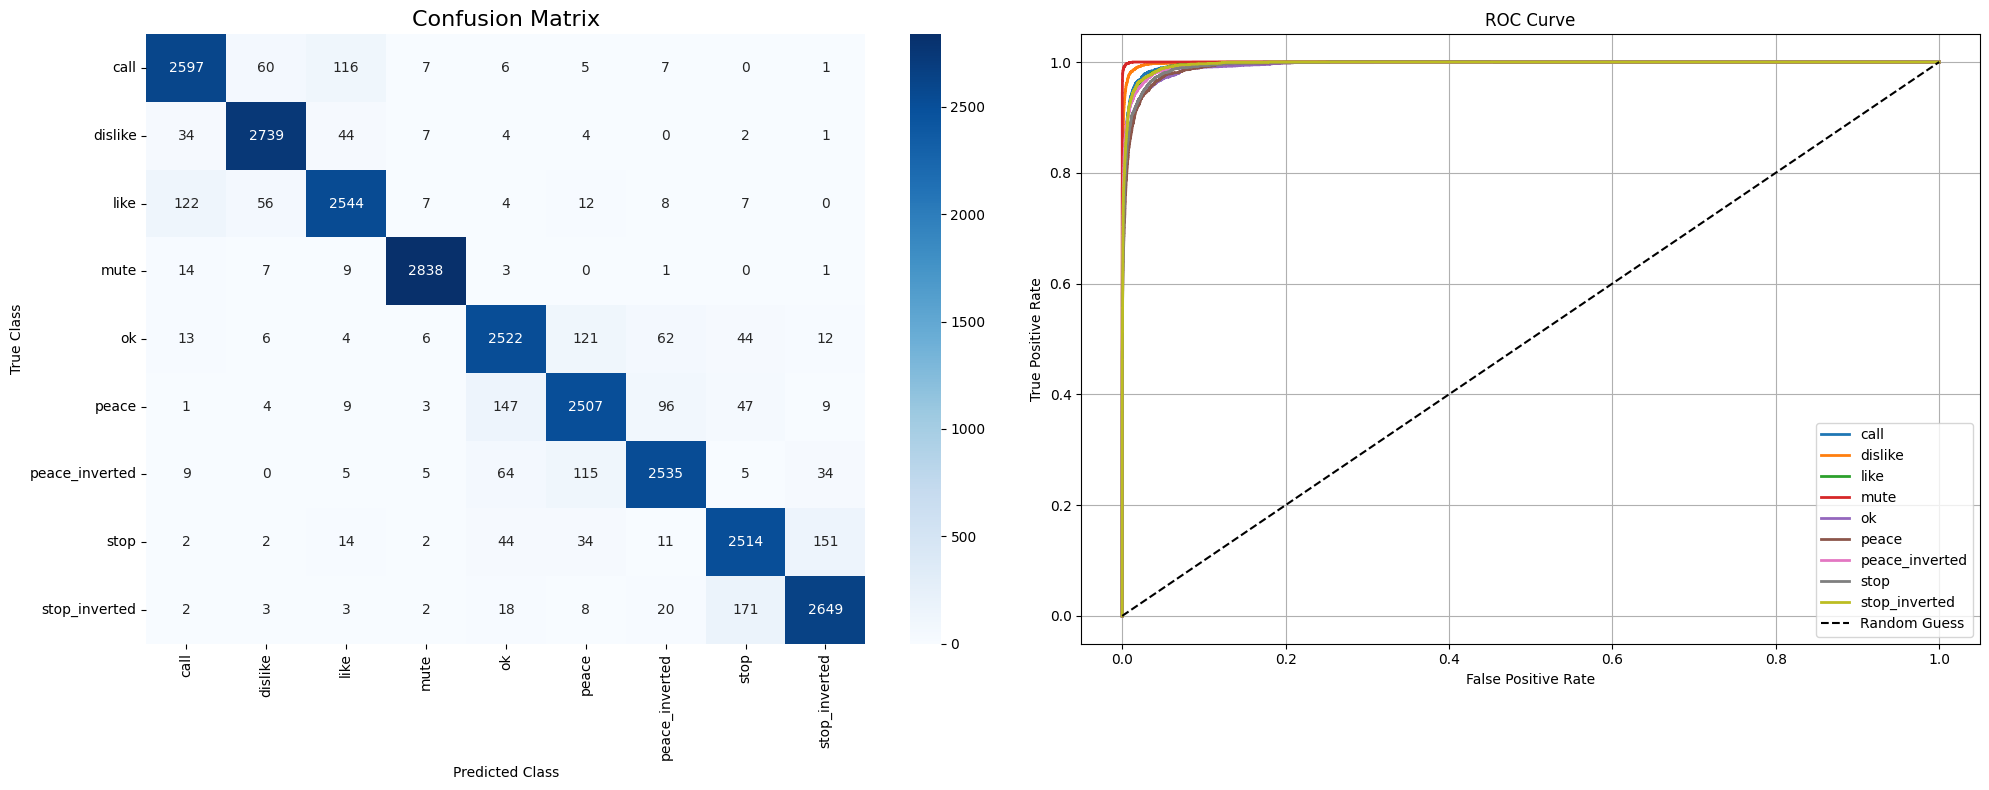

In [6]:
best_model, _ = model_utils.get_model(model_name='vit',num_classes=9, device=device)
best_model.load_state_dict(torch.load('/kaggle/working/unzipped_data/ViT',map_location=device))
vis_utils.evaluate_best_model(model=best_model,
                              loss_fn=loss_fn,
                              dataloader=test_dataloader,
                              class_names=class_names,
                              device=device)

## 2.3 TensorBoard

YOUR_NGROK_TOKEN_HERE -> [YOUR_NGROK_TOKEN_HERE](https://dashboard.ngrok.com/get-started/your-authtoken) **(Looks like - 2Fj7...5kL9...)**

In [ ]:
# 1. KILL previous processes
os.system("pkill -f tensorboard")
ngrok.kill()

# 2. HIDE TensorFlow Warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# 3. Authenticate Ngrok
ngrok.set_auth_token("YOUR_TOKEN_HERE") 

# 4. Start the Tunnel
try:
    public_url = ngrok.connect(6006).public_url
    print(f"TensorBoard is live at: {public_url}")
except Exception as e:
    print(f"Ngrok Error: {e}")

# 5. Start TensorBoard Silently
subprocess.Popen(
    ['tensorboard', '--logdir', '/kaggle/working/unzipped_data/runs', '--host', '0.0.0.0', '--port', '6006'],
    stdout=subprocess.DEVNULL,
    stderr=subprocess.DEVNULL
)

🚀 TensorBoard is live at: https://overstimulatively-unpilfered-bethann.ngrok-free.dev


<Popen: returncode: None args: ['tensorboard', '--logdir', '/kaggle/working/...>